# Project-2: Advance Lane Line Finding

# 1-  Camera Clibraton
<font size='3'>
Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

- camera_cal folder were used to call 20 images, three of these images did not go throught the cailbraton
- cv2.findChessboardConrners() werer used to find the corners of 9x6 chess board 
- Then it returns ret(flag) and courners, which is  the positions of internal corners of the chessboard 
- cv2.calibrateCamera() is used to camera matrix and distortion coefficients
- Finally I undistorted  a distorted image using cv2.undistort

#### Notes: 
The following images were skipped in the camera_calibration function, that because. 

The associated ret == False which means that cv2.findChessboardCorners did not found the corners of them
my conclusion is as follow.
- image calibration1.jpg, the sixth ny corner is difficult to read. so it sees 9x5 corners not 9x6
- image calibration4.jpg, the sixth ny corner is difficult to read. the same reason as above
- image calibration5.jpg, the eight nx corner is difficult to read. so it sees 8x6

</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob 
import matplotlib.image as mpimg
from IPython.core.debugger import set_trace
import pickle
%matplotlib inline

Skipped Images:
  ['camera_cal\\calibration1.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg']


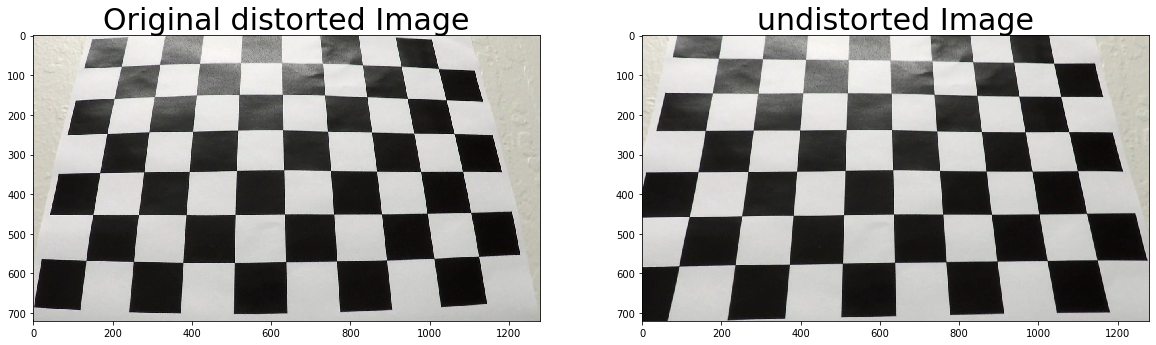

In [2]:

# cheese board x and y numbers 
nx = 9
ny = 6

def camera_calibration(images ,distorted_img, nx, ny):
    objpoints = [] # 3D points in real world
    imgpoints = [] # 2D points in image plane
    skipped_images = []

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    
    for i in images:
        img = mpimg.imread(i)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

        #if image corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            skipped_images.append(i)
            
    img_size = (distorted_img.shape[1],distorted_img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)  
    
    #show an example of undistorting a distorted image
    dst = cv2.undistort(distorted_img, mtx, dist, None, mtx)    
 
    return ret, mtx, dist, rvecs, tvecs, skipped_images, dst
    

#read images for calibration 
images = glob.glob('camera_cal/calibration*.jpg')

# read a test image to test calibration function
distorted_img = mpimg.imread('camera_cal/calibration3.jpg')

ret, mtx, dist, rvecs, tvecs, skipped_images, undistorted_image = camera_calibration(images, distorted_img, nx, ny)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_img)
ax1.set_title('Original distorted Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('undistorted Image', fontsize=30)

# The following images were skipped in the camera_calibration function, that because 
# The associated ret == False which means that cv2.findChessboardCorners did not found the corners of them
# my conclusion is as follow
# 1- image calibration1.jpg, the sixth ny corner is difficult to read. so it sees 9x5 corners not 9x6
# 2- image calibration4.jpg, the sixth ny corner is difficult to read. the same reason as above
# 3- image calibration5.jpg, the eight nx corner is difficult to read. so it sees 8x6
#
# in conclusion those are not good for cailibration 
print("Skipped Images:\n ", skipped_images)

# 3- Use color transforms, gradients, etc., to create a thresholded binary image.

#### the img_thresholds() fucntion perform gradients and color transforms as follow 
1. first abs_sobel_thresh, finds the gradints value on the x (gradx) and y (grady) diretion
2. Then mag_binary() Calculate gradient magnitude
3. After that, the dir_threshold() Calculats gradient direction
5. Then, the hls_threshold() finds color transfore on the s channel 
6. Finally the gradient and color transforms images are combind to gether to produce **combined_binary** image 
and ignore the rest becuase of the noise they produce. 
1. xxx
2. xxx
3. xx


having a second thought I deceided to used only the following threshold methods 

In [77]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    gradient = (255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(gradient)
    grad_binary[(gradient >= thresh[0]) & (gradient <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    gradmag = (255*gradmag/np.max(gradmag)).astype(np.uint8)
    
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    dir_gradient = np.arctan2(sobely, sobelx)
    binary_output = np.zeros_like(dir_gradient)
    binary_output [(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1]) ] = 1    
    return binary_output



    
def hls_threshold(undst, s_thresh_min = 180, s_thresh_max = 255):
    hls = cv2.cvtColor(undst, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    return s_binary
    
def img_thresholds(img):

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=17, thresh=(40, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=17, thresh=(50, 255))
    mag_binary = mag_thresh(img, sobel_kernel=17, mag_thresh=(50, 200))
    dir_binary = dir_threshold(img, sobel_kernel=21, thresh=(0.7, 1.3))
    s_binary = hls_threshold(img, s_thresh_min = 90, s_thresh_max = 255)



    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    
    return combined_binary, combined, s_binary, dir_binary, mag_binary, grady, gradx


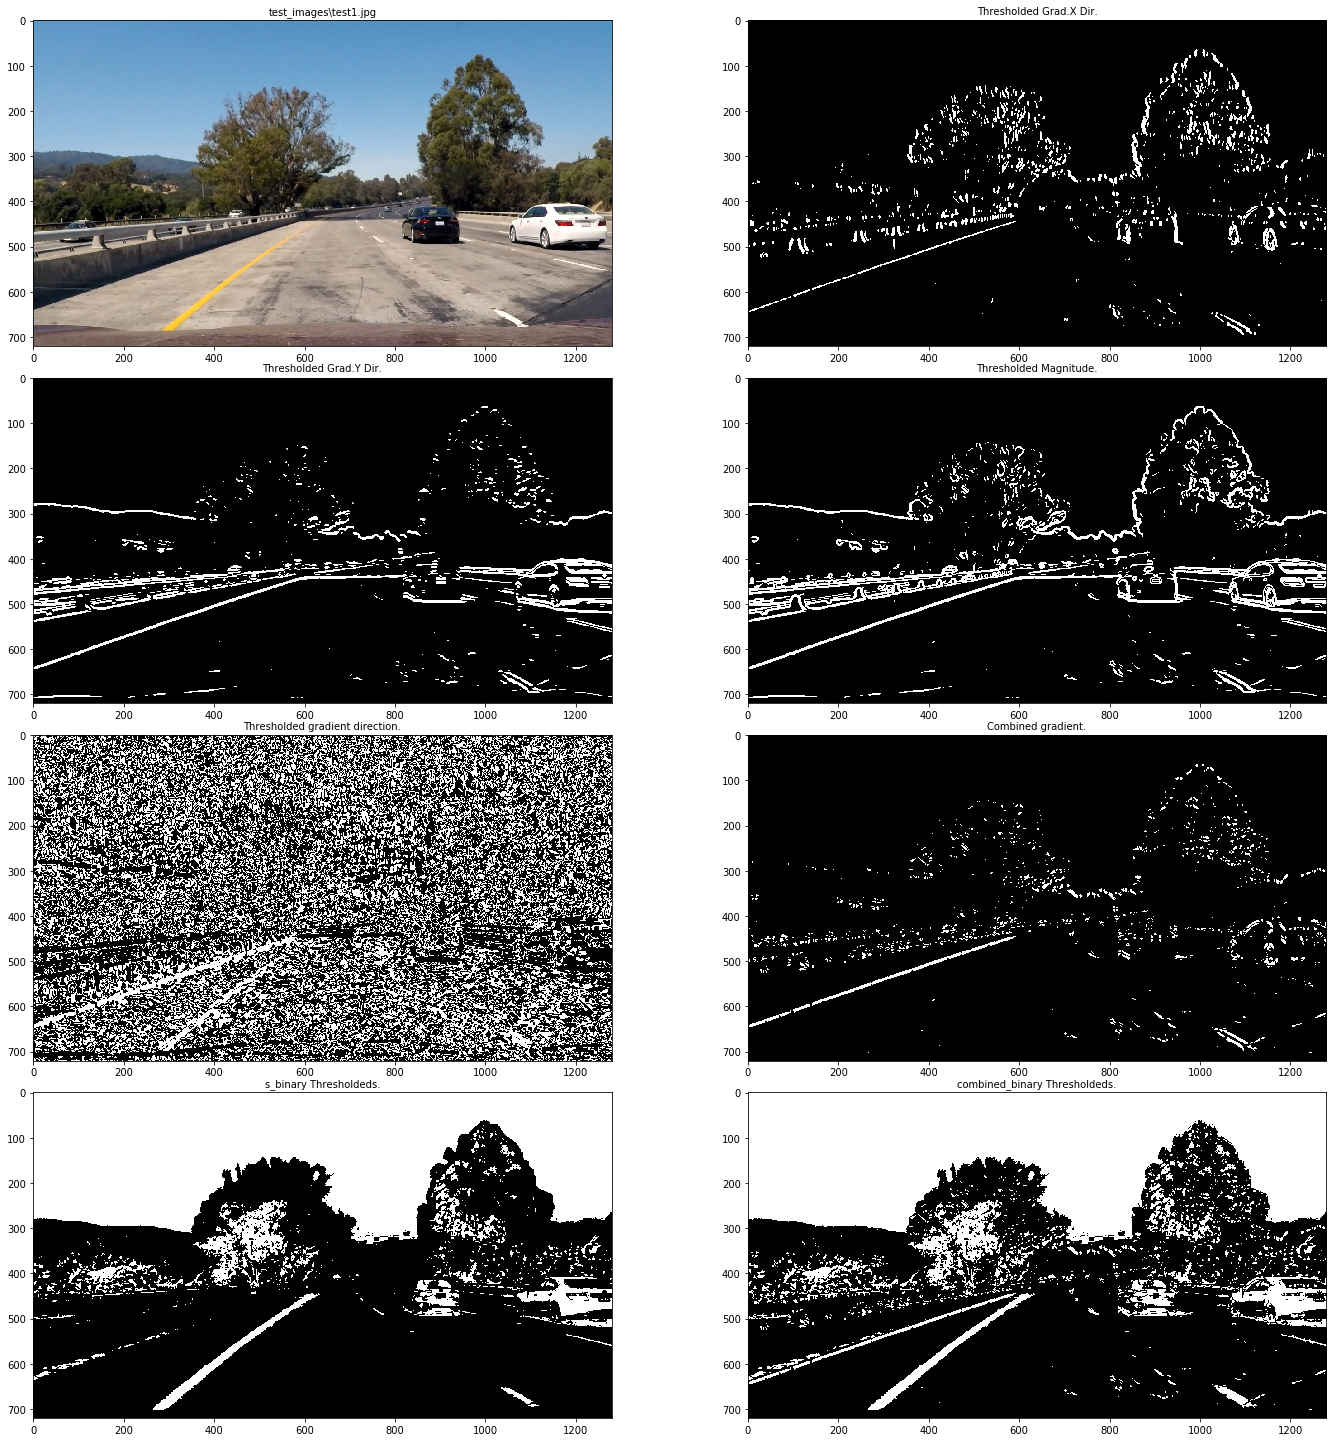

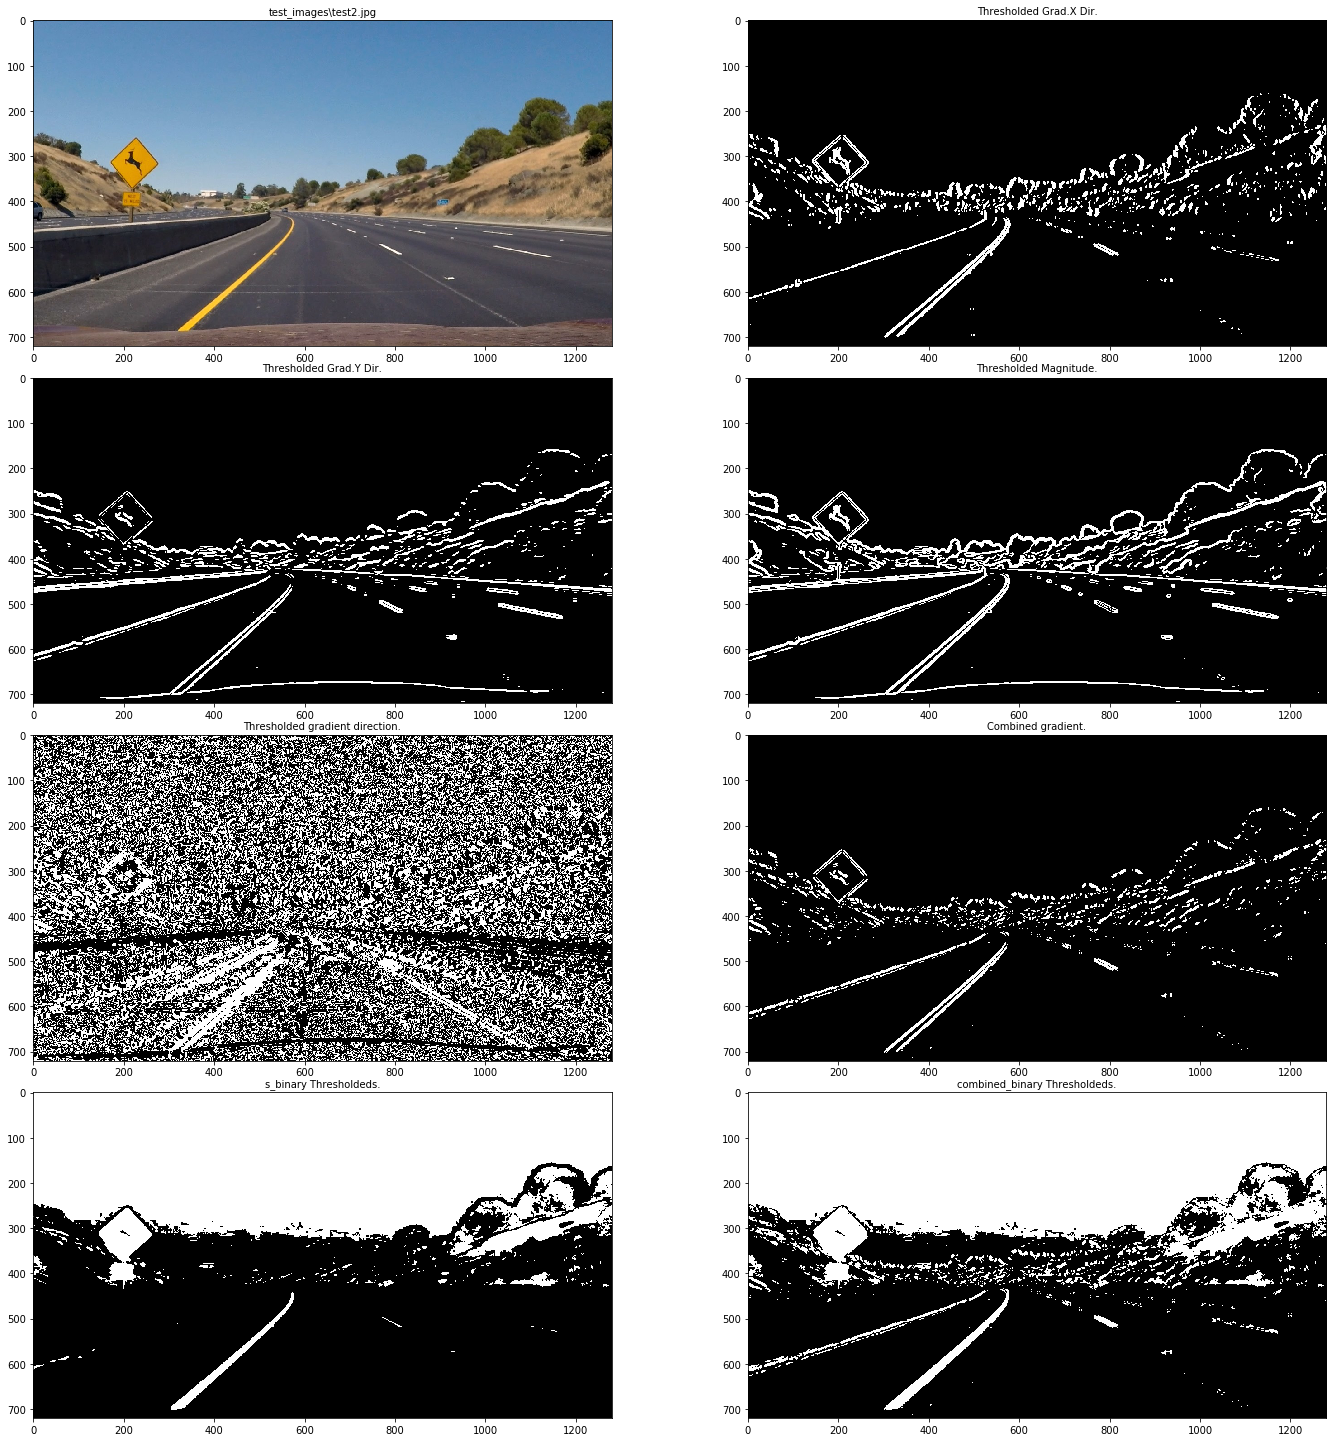

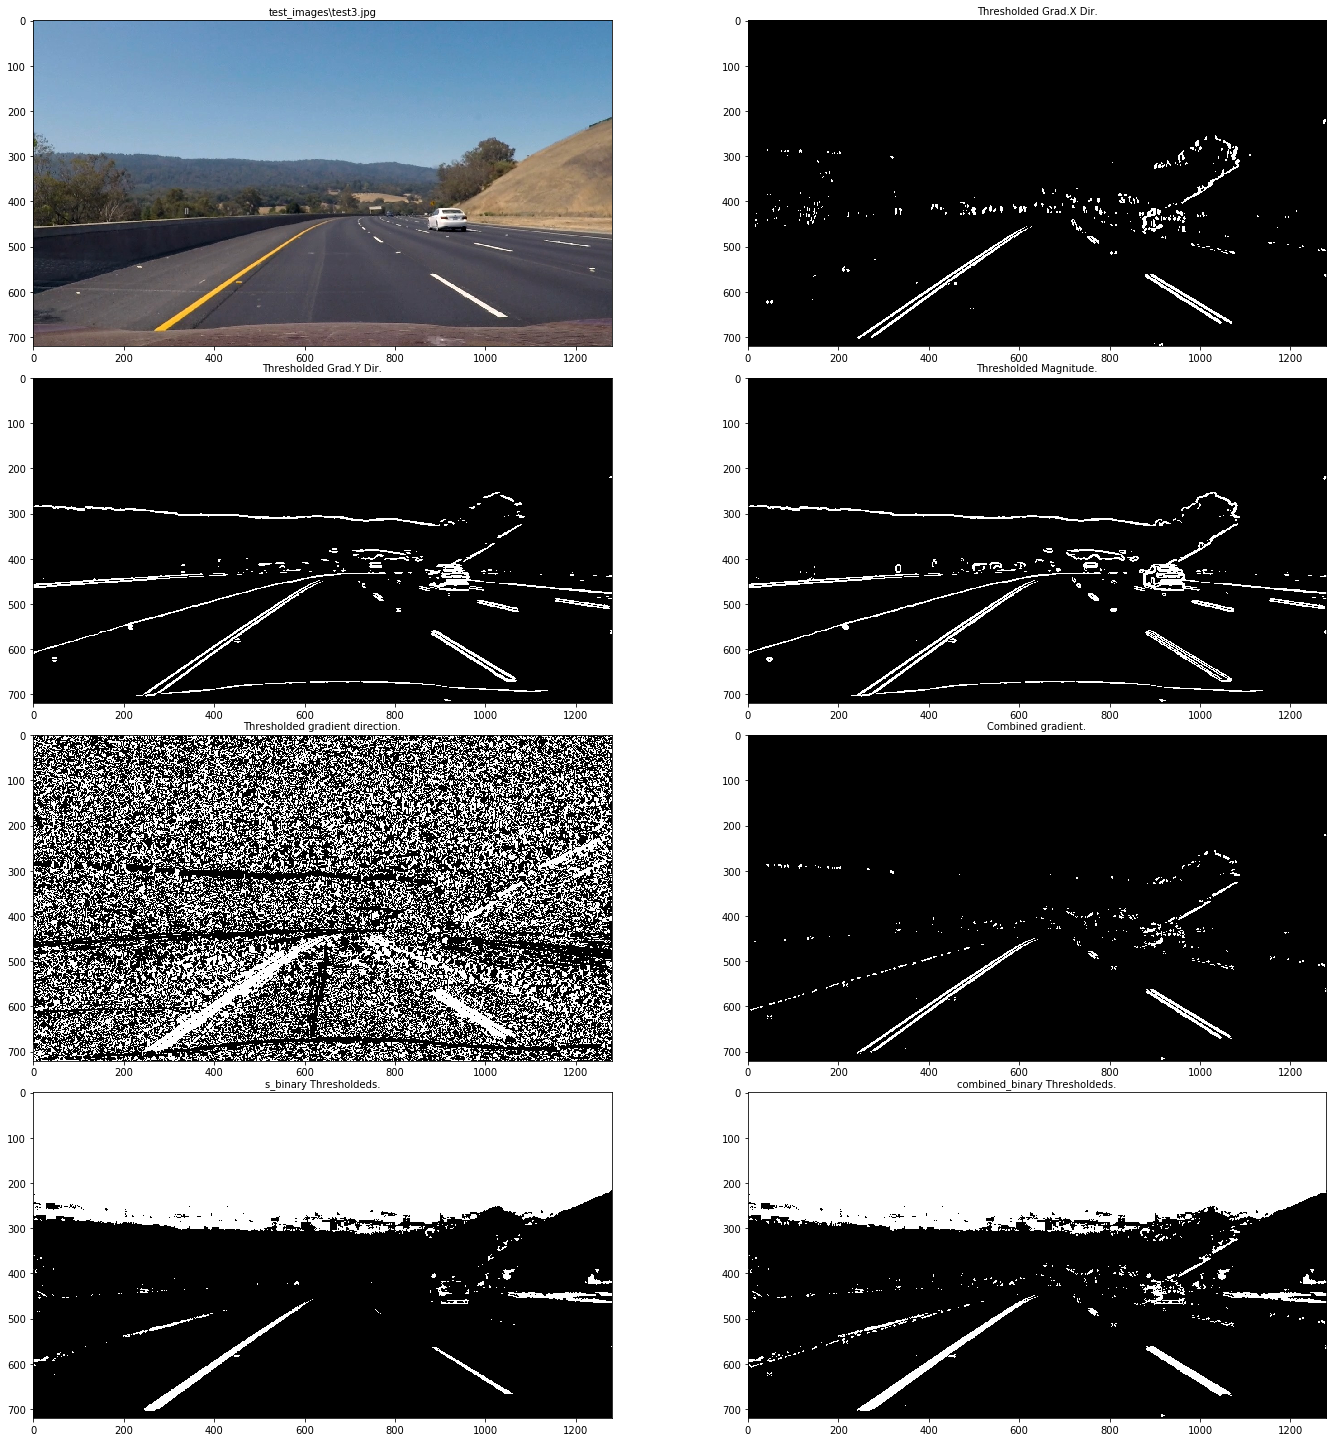

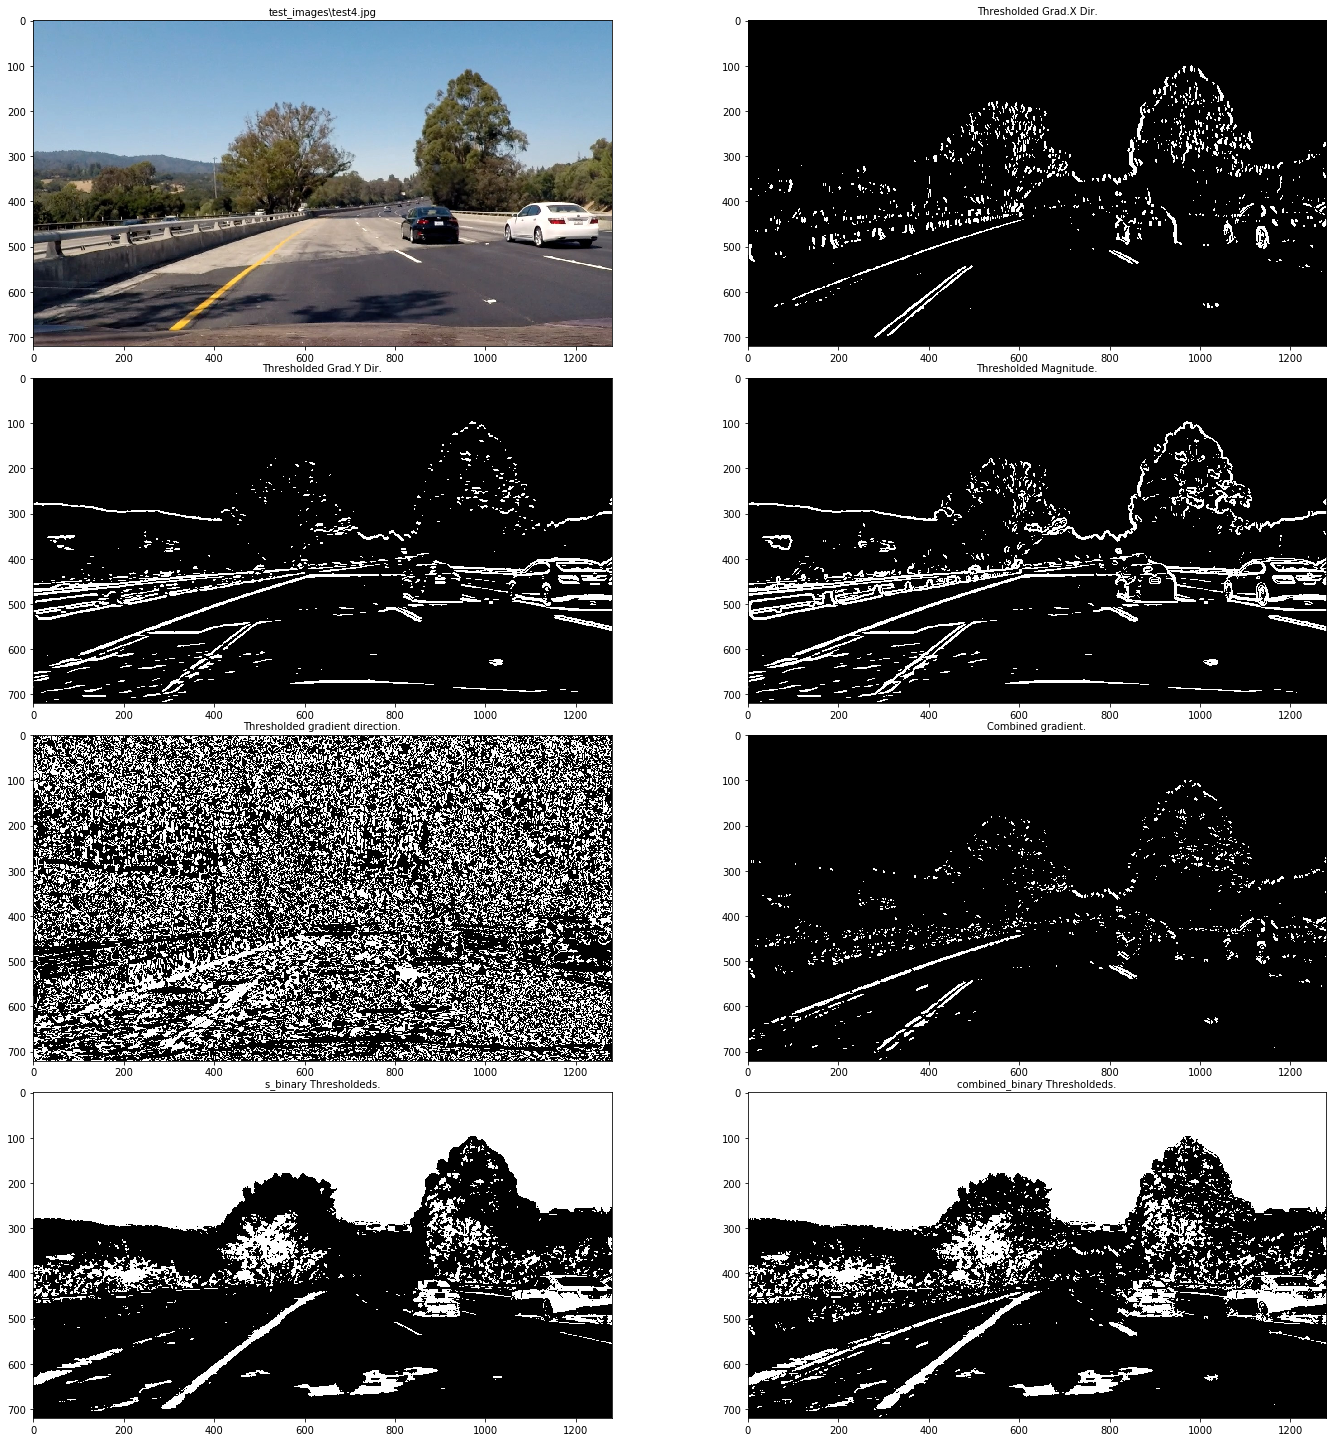

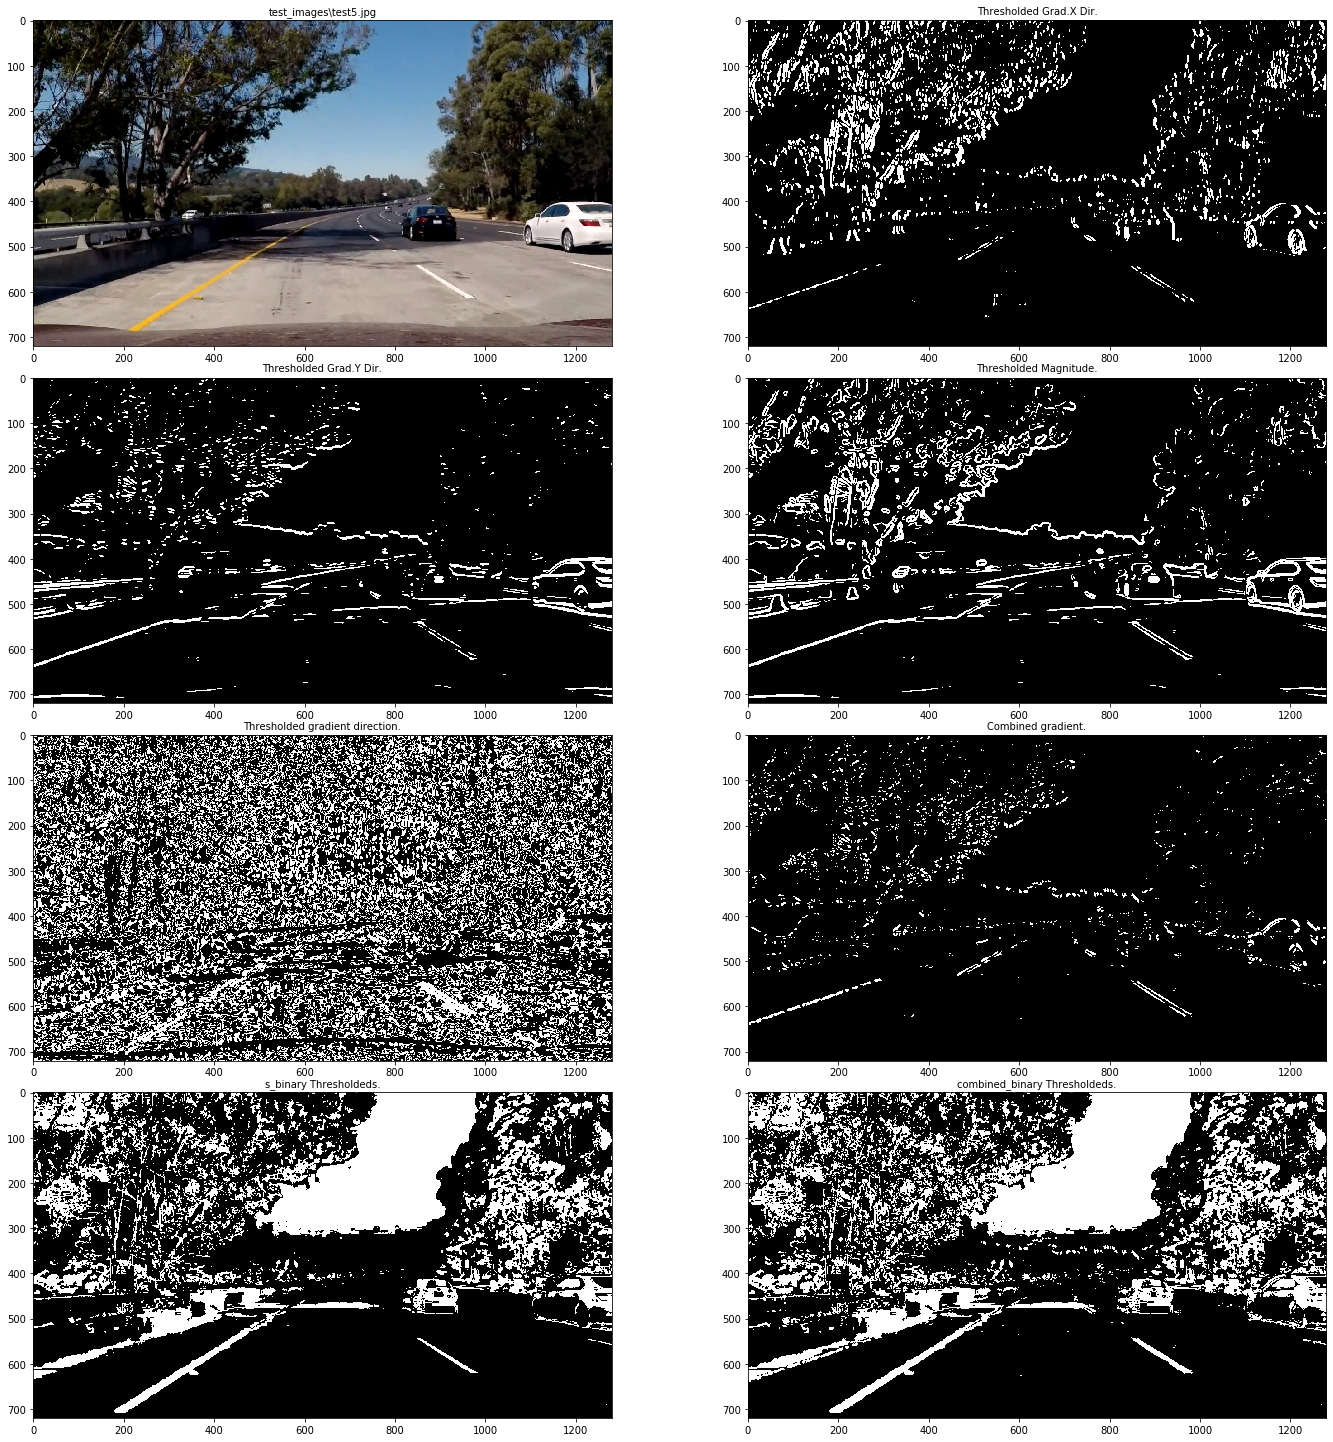

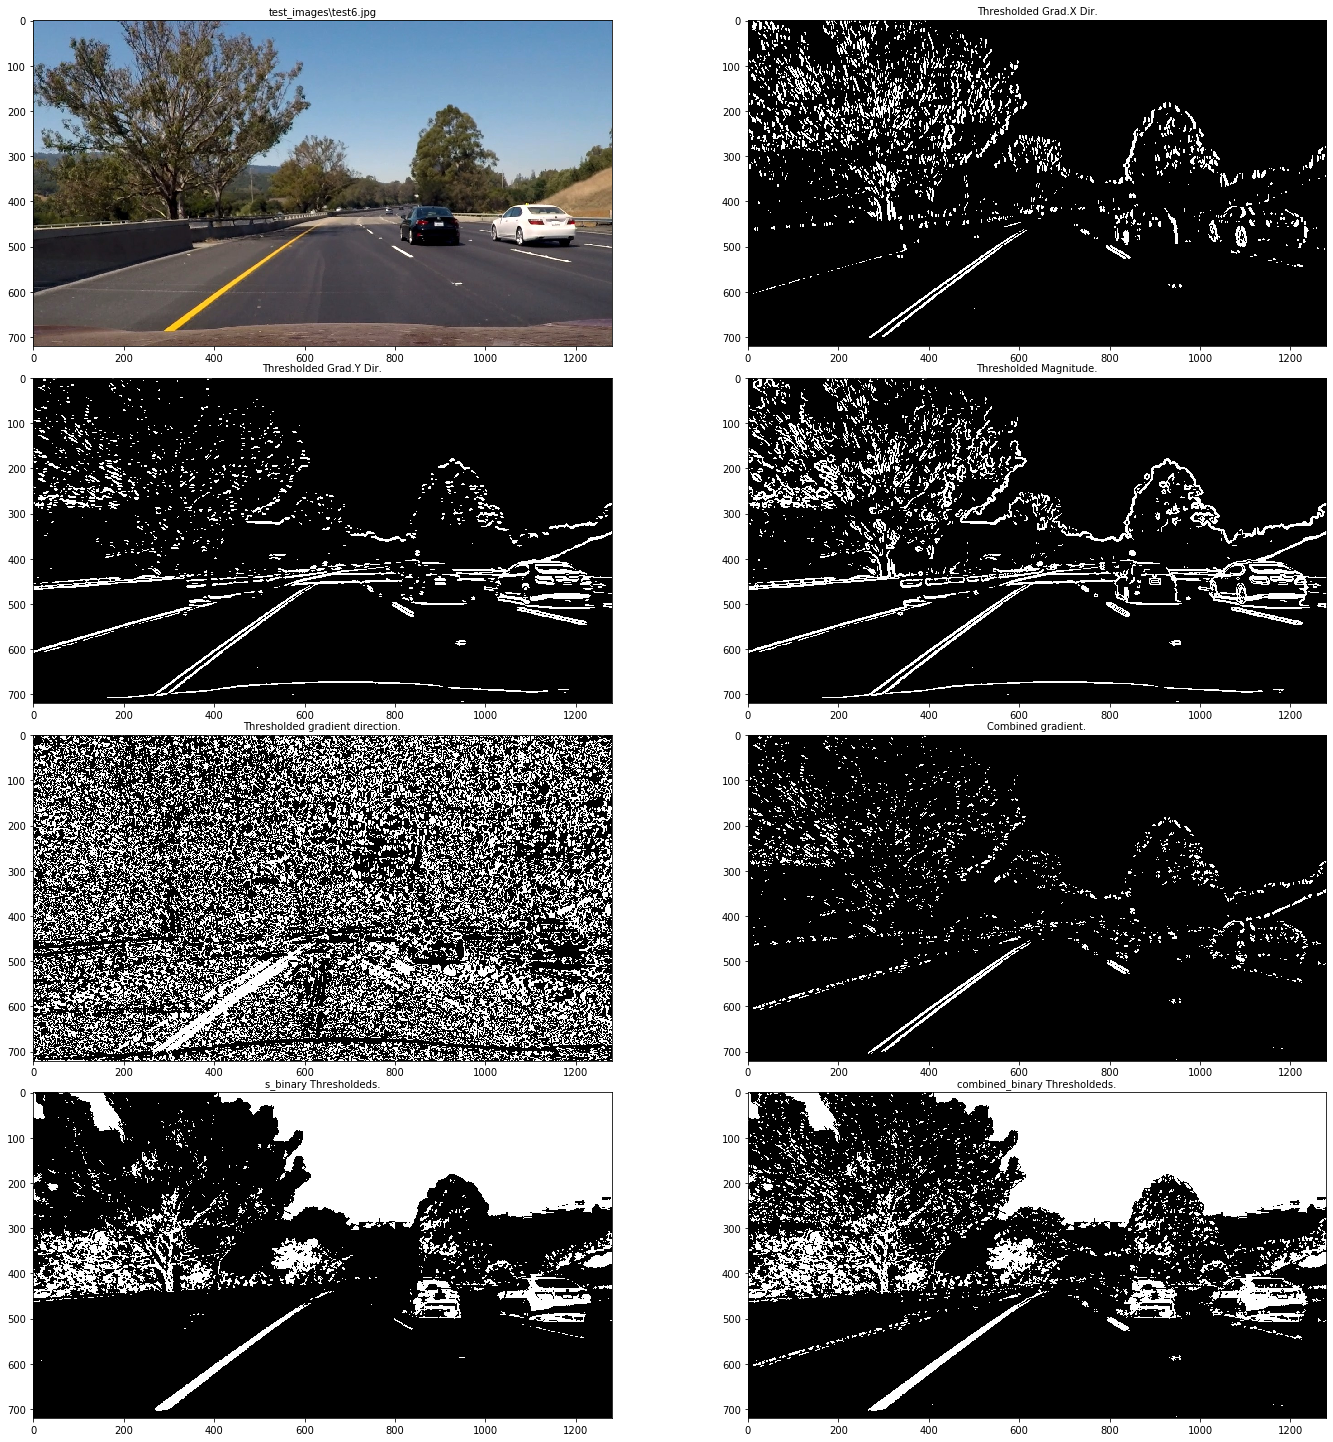

In [78]:
images = glob.glob('test_images/test*.jpg')

for img in images:
    
    image = mpimg.imread(img) 
    undst = cv2.undistort(image, mtx, dist, None, mtx)
    combined_binary, combined, s_binary, dir_binary, mag_binary, grady, gradx = img_thresholds(undst)
# 
    # Plot the result
    f, ax = plt.subplots(4, 2, figsize=(20, 20))
    f.tight_layout()
    ax[0][0].imshow(image)
    ax[0][0].set_title(img, fontsize=10)
    ax[0][1].imshow(gradx, cmap='gray')
    ax[0][1].set_title('Thresholded Grad.X Dir.', fontsize=10)
    ax[1][0].imshow(grady, cmap='gray')
    ax[1][0].set_title('Thresholded Grad.Y Dir.', fontsize=10)
    ax[1][1].imshow(mag_binary, cmap='gray')
    ax[1][1].set_title('Thresholded Magnitude.', fontsize=10)
    ax[2][0].imshow(dir_binary, cmap='gray')
    ax[2][0].set_title('Thresholded gradient direction.', fontsize=10)
    ax[2][1].imshow(combined, cmap='gray')
    ax[2][1].set_title('Combined gradient.', fontsize=10)  
    ax[3][0].imshow(s_binary, cmap='gray')
    ax[3][0].set_title('s_binary Thresholdeds.', fontsize=10)
    ax[3][1].imshow(combined_binary, cmap='gray')
    ax[3][1].set_title('combined_binary Thresholdeds.', fontsize=10)
    
#     plt.subplots_adjust(left=0.125, right=0.9, top=0.9, bottom=0.1)

# 4- Apply a perspective transform to rectify binary image ("birds-eye view").

In [ ]:
def warp(img):
    img_size = (img.shape[1],img.shape[0])
    
    # Four source cordinate
#     src = np.float32([[490, 482],[810, 482],
#                       [1250, 720],[40, 720]])
#     dst = np.float32([[0, 0], [1280, 0], 
#                      [1250, 720],[40, 720]])
    src = np.float32(
        [[120, img_size[1]],
        [560,450],
        [1200, img_size[1]],
        [750,450]])
    dst = np.float32(
        [[250, img_size[1]],
        [100, 0],
        [900, img_size[1]],
        [1200, 0]])
#     src = np.float32(
#         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#         [((img_size[0] / 6) - 10), img_size[1]],
#         [(img_size[0] * 5 / 6) + 60, img_size[1]],
#         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
#     dst = np.float32(
#         [[(img_size[0] / 4), 0],
#         [(img_size[0] / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), 0]])
    
    #Compute the perspective transform , M
    M = cv2.getPerspectiveTransform(src,dst)
    
    #Could comput the invrese also by swapping the input perameters
    Minv = cv2.getPerspectiveTransform(dst,src)    
    
    # create a wrawped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

In [ ]:
images = glob.glob('test_images/test*.jpg')

for img in images:
    
    image = mpimg.imread(img) 
    undst = cv2.undistort(image, mtx, dist, None, mtx)
    warped, Minv = warp(undst)
    
    f, ax = plt.subplots(1, 2, figsize=(24, 24))
    ax[0].imshow(undst, cmap="gray")
    ax[0].set_title('Original undistorted Image', fontsize=30)
    ax[1].imshow(warped, cmap='gray')
    ax[1].set_title('wraped Image', fontsize=30)

# 4- Detect lane pixels and fit to find the lane boundary.

In [ ]:


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#         set_trace()
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return out_img, left_fit, right_fit



out_img, left_fit, right_fit = fit_polynomial(combined_binary)


plt.imshow(out_img)



### Finding the Lines: Search from Prio, Skip the sliding windows step once you've found the lines


In [ ]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
# left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
# right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    

    ## End visualization steps ##
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return result, left_fitx, right_fitx, ploty




# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty = search_around_poly(combined_binary)

# View your output
# Plot the polynomial lines onto the image

plt.imshow(result)

# 5- Determine the curvature of the lane and vehicle position with respect to center.

In [ ]:
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meters per pixel in x dimension
#     left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, (leftx*xm_per_pix), (lefty*ym_per_pix), (rightx*xm_per_pix), (righty*ym_per_pix))
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, right_curverad)

# Warp the detected lane boundaries back onto the original image.

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:

In [ ]:
# Create an image to draw the lines on
def visual_display():
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    plt.imshow(result)
visual_display()

# pipline 

In [ ]:

image = mpimg.imread('test_images/test1.jpg')  
undst = cv2.undistort(image, mtx, dist, None, mtx)

# 1- camera caliberation 
 ## It has been done at the starte of this notebook, no need to do it agian 

# 2- color transforms, gradients, etc., to create a thresholded binary image
combined_binary = img_thresholds(undst)

# 3- Apply a perspective transform to rectify binary image
binary_warped, Minv = warp(combined_binary)

# 4- Detect lane pixels and fit to find the lane boundary.
out_img, left_fit, right_fit = fit_polynomial(binary_warped)

# Finding the Lines: Search from Prio, Skip the sliding windows step once you've found the lines
result, left_fitx, right_fitx, ploty = search_around_poly(binary_warped)

# 5- Determine the curvature of the lane and vehicle position with respect to center.
visual_display()
# plt.imshow(result,  cmap="gray")